# Exploratory Data Analysis |  Modeling Spotify track popularity
## Leo Evancie, Springboard Data Science Career Track

This is the second step in a capstone project to model music popularity on Spotify, a popular streaming service. Further project details and rationale can be found in the document 'Proposal.pdf'.

In this notebook, I will take a deeper dive into my cleaned dataset of nearly 10,000 tracks pulled from Spotify's API. I will visualize key relationships and look for clues to help guide the later development of my model.

First, I'll load packages and read my cleaned data into a DataFrame:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('../data/cleaned.csv', index_col=0)

## 1. Target inspection

The target of my model is track `popularity`. I inspected this column while data wrangling. Here, again, is its distribution:

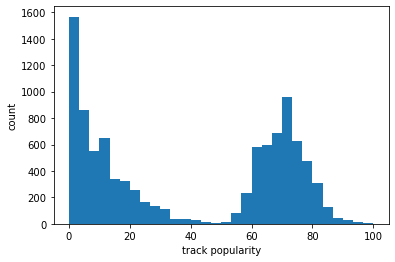

In [10]:
plt.hist('popularity', data=df, bins=30)
plt.xlabel('track popularity')
plt.ylabel('count')
plt.show()

As mentioned in the previous notebook, the large number of tracks with a `popularity` of zero means that a classification model may be more appropriate, rather than trying to model the specific value from 0 to 100. Looking at the above distribution, a score of 50 or higher seems like a good cutoff. I can use that to create a new, binary representation of popularity.

In [11]:
df['popularity_class'] = np.where(df.popularity >= 50, 1, 0)
df.rename(columns={'popularity':'popularity_int'}, inplace=True)
df[['popularity_int', 'popularity_class']].head(10)

,popularity_int,popularity_class
0,82,1
1,58,1
2,60,1
3,33,0
4,76,1
5,56,1
6,78,1
7,25,0
8,81,1
9,51,1


That seems to have worked. How many popular tracks do I have here?

In [12]:
np.sum(df.popularity_class) / len(df)

0.48568818514007306

It's an even split. This is good. If popular tracks were the vast minority or majority, a classification model would not be as interesting. I will continue my analysis with this new `popularity_class` column as the target, but I'll keep `popularity_int` in the dataset. I may need to come back to it later.

## 2. Feature inspection

I will begin the process of examining individual features, as well as their relationship to `popularity_class`. I need a reminder of all the features I'm working with.

In [13]:
df.columns

Index(['track_id', 'name', 'artist', 'album', 'year', 'popularity_int',
       'duration_ms', 'explicit', 'track_number', 'disc_number',
       'available_markets', 'album_type', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'mode', 'key',
       'available_markets_total', 'collab', 'popularity_class'],
      dtype='object')

### i. Track and disc number

Let's start with `track_number`. This indicates the position of the track on its corresponding album. Not all tracks are part of albums; I'll expand on this shortly. What values of `track_number` exist in my dataset?

In [14]:
df.track_number.value_counts()

1      1870
2       874
3       819
4       666
5       594
       ... 
105       5
106       2
122       1
107       1
111       1
Name: track_number, Length: 109, dtype: int64

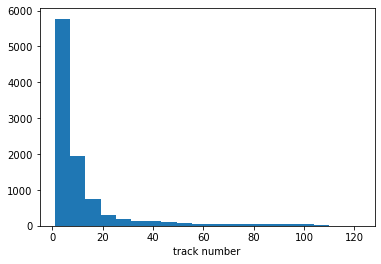

In [15]:
plt.hist('track_number', data=df, bins=20)
plt.xlabel('track number')
plt.show()

Track number appears to be exponentially distributed. This makes intuitive sense. Typically, an album has somewhere around 12 tracks, while anthologies and compliations have more, with successively higher track numbers being decreasingly common. As such, I'm curious about the much higher track numbers. What kinds of collections have track numbers in the 50s, 60s, even over 100? I can't remember ever encountering such an album.

I will isolate the tracks with notably high track numbers and inspect.

In [16]:
high_tracks = df[df['track_number'] > 40][['name','artist','popularity_class','track_number']]\
    .sort_values('track_number', ascending=False)
high_tracks.head(10)

,name,artist,popularity_class,track_number
8597,Stay Loud - Official Decibel outdoor 2020 Tribute,Frequencerz,0,122
7485,Wish Outdoor 2019 Worldwide Anthem,Frequencerz,0,111
5659,A State Of Trance Year Mix 2017 - A Magical Pa...,Armin van Buuren,0,107
7449,A State Of Trance Year Mix 2019 (Mixed) - Outr...,Armin van Buuren,0,106
5623,Leave A Message (Mix Cut),Will Atkinson,0,106
8379,A State Of Trance Year Mix 2020 (Mixed) - Road...,Armin van Buuren,0,105
7317,Stickup (Mixed) - Maarten de Jong Remix,Armin van Buuren,0,105
5743,Wraith (Mix Cut),DRYM,0,105
6443,A State Of Trance Year Mix 2018 (Mixed) - Outr...,Armin van Buuren,0,105
5927,Wraith,DRYM,0,105


As expected, there are just a few artists accounting for the bulk of the high track numbers. (If an artist has a song with track number 100, there's a good chance the sample will include other songs by the same artist with track numbers 99, 98, etc.) Just how many artists appear in this high-track subset?

In [17]:
high_track_artists = high_tracks.artist.unique()
len(high_track_artists)

237

How does that compare to the total artists?

In [18]:
len(high_track_artists) / len(df.artist.unique())

0.07655038759689922

Just 0.08% of artists in the sample have any tracks with a higher track number than 40. What about the numbers of tracks?

In [19]:
len(high_tracks) / len(df)

0.06699147381242387

So, a similar proportion of tracks in the sample -- about 0.07% -- have a `track-number` higher than 40. This is such a small slice that it's tempting to remove it from the sample entirely. However, I see that all ten of the above high-number tracks are unpopular. Is that just a coincidence? Let's look at the relationship between `track_number` and `popularity_class`. I'll define a function to plot the proportion of popular tracks over a given numeric feature, since I have a feeling I'll want to do this a few more times.

In [20]:
def pop_prop_scatter(x):
    """Create scatterplot of the proportion of popular tracks over a given numeric feature"""
    pop_prop_by_x = df[[x, 'popularity_class']].sort_values(x).groupby(by=x).mean()
    _ = sns.relplot(x=pop_prop_by_x.index, y='popularity_class', data=pop_prop_by_x, kind='scatter')
    _.set(title='Popularity by {}'.format(x), xlabel=x, ylabel='Proportion of popular tracks')
    plt.show()

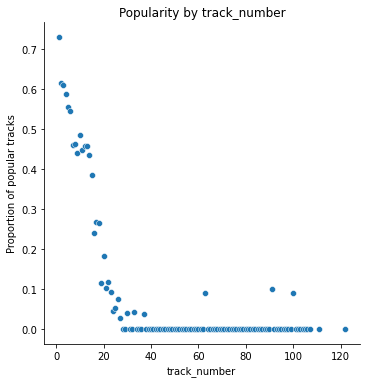

In [21]:
pop_prop_scatter('track_number')

While over 70% of tracks where `track_number` = 1 are popular, popularity drops off in a roughly linear fashion, up to about track number 25. Track numbers above that tend to have very low to no popularity, though of course we have very few tracks corresponding to those high track numbers.

There's more context to unpack here, but first, I'll take a quick look at `disc_number`. This would only be pertinent to multi-disc compilations, which are presumably quite rare. I also don't expect to see disc numbers much higher than low single-digits.

In [22]:
df.disc_number.value_counts()

1     8911
2      618
3      100
4       68
5       44
10      27
6       27
7       18
9       17
8        8
11       5
13       5
12       4
Name: disc_number, dtype: int64

As expected, the vast majority of `disc_number` values are 1, with a small handful of larger numbers, such that I think we can safely disregard this feature entirely.

Upon further consideration of `track_number`, it ultimately seems best to exclude track number from the feature space as well. I suspect it can only introduce bias to the model. Further down the road, if the modeling process leads me to conclude that I need more features, I may explore reintroducing `track_number`.

### ii. Album type

So, `track_number` appears to have a systematic effect on popularity. But to fully understand the relationship, we must explore the notion of a "single." Artists often do not release entire albums, but single standalone tracks. In such cases, the `track_number` value would presumably be 1. This could potentially cause misinterpretation of the simple relationship between track number and popularity. For example, if

* singles have `track_number` 1 in the dataset, and
* singles tend to be more popular than tracks from albums, (which seems likely, due to the prevalence of singles in pop music),

then we would see an artificially inflated importance of early track numbers (particularly track number 1) in predicting popularity.

I will split the data into singles and albums to reassess the popularity distributions and associations. The relevant information is stored in the `album_type` column.

In [23]:
singles = df[df.album_type == 'single']
albums = df[df.album_type != 'single']

In [24]:
len(singles) / len(df)

0.14514819326025172

Singles make up 14.5% of the sample. Let's test the first assumption from above: Singles in the dataset have `track_number` = 1.

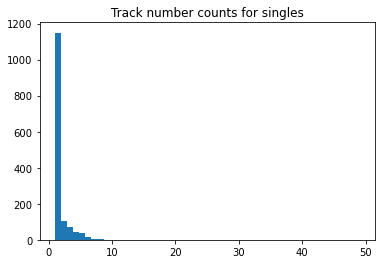

In [25]:
plt.hist(singles.track_number, bins=50)
plt.title('Track number counts for singles')
plt.show()

I see that this assumption was not entirely correct. While the vast majority of singles have `track_number` = 1, and there is some clustering around values greater than one, the distribution is much narrower than what we saw above in the overall distribution of `track_number`. Singles do, in fact, appear more likely to have `track_number` = 1.

Now let's check assumption two: Singles are more popular.

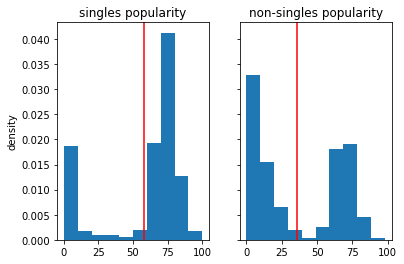

In [26]:
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].hist('popularity_int', data=singles, density=True, bins=10)
axs[0].axvline(singles.popularity_int.mean(), color='r')
axs[0].set_title('singles popularity')
axs[0].set_ylabel('density')
axs[1].hist('popularity_int', data=albums, density=True, bins=10)
axs[1].axvline(albums.popularity_int.mean(), color='r')
axs[1].set_title('non-singles popularity')

plt.show()

For singles, popularity is distributed unimodally, with the addition of a cluster of zeroes. Even with said cluster, the mean is much higher than the popularity of non-single tracks, which has a bimodal distribution, with a greater density of tracks in the low range. Overall, assumption #2 appears to be correct

Therefore, I need to be mindful when ascribing importance of `track_number` to popularity. Part of the covariance between these two variables can be explained by whether or not the track is a single.

And so, as I did with popularity, I will create a new binary column to indicate whether a track is a `single`.

In [27]:
df['single'] = np.where(df['album_type'] == 'single', 1, 0)
df[['album_type', 'single']].head(10)

,album_type,single
0,album,0
1,album,0
2,album,0
3,single,1
4,album,0
5,single,1
6,single,1
7,single,1
8,album,0
9,single,1


### iii. Danceability

One of the Spotify-provided quantitative features I'm interested in `danceability`. However they may have defined this concept, one wonders if `danceability` has some bearing on popularity. If you pause to consider the sheer number of people who probably use Spotify to provide entertainment for parties, it's reasonable to predict that "danceable" tracks get more play. Let's find out.

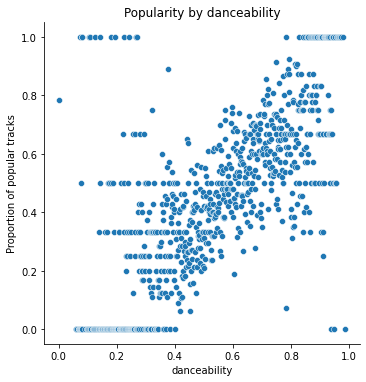

In [28]:
pop_prop_scatter('danceability')

Interesting. There's definitely a positive association, as predicted. I also see several horizontal bands of points. This is to be expected given how popularity proportion was calculated. For example, if there are very few tracks with a given `danceability` score, the proportion of those tracks which are popular will be one of a few common fractions. Those are the horizontal lines we see above. I think this definitely still qualifies as a worthwhile feature to include in the model.

### iv. Other musical quality metrics

The dataset includes a handful of other such features, where a subjective musical concept is quantified between 0 and 1. Let's visualize each of their respective relationships to popularity as we did above.

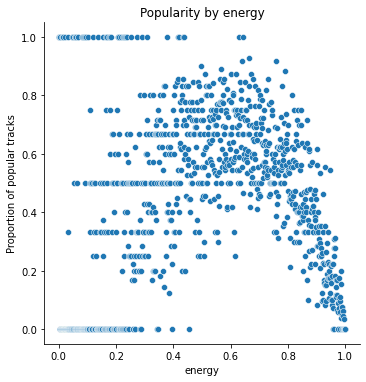

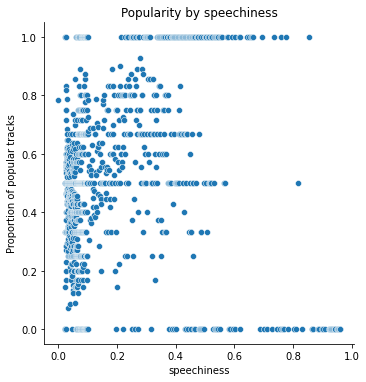

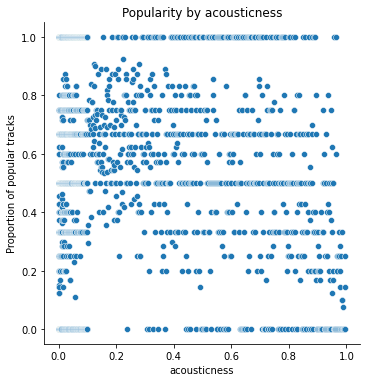

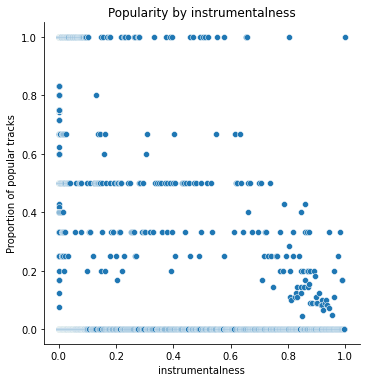

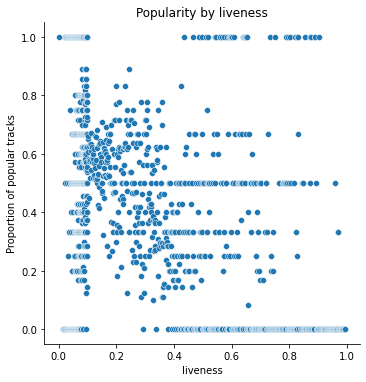

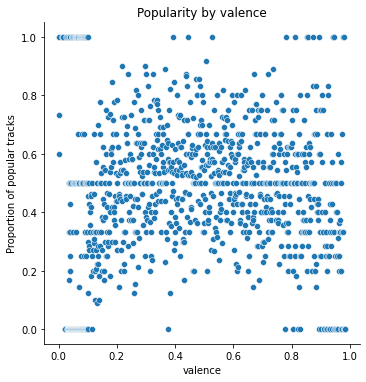

In [29]:
for i in ['energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']:
    pop_prop_scatter(i)

Many of these plots look pretty noisy, and do not appear to show a systematic relationship. The `energy` plot, though, is interesting. It almost looks quadratic -- certainly not random. I also notice a modest cluster of points in the lower-right quadrant of the `instrumentalness` plot, suggesting a small chunk of very instrumental, very unpopular tracks. I would pick out those two features, in addition to `danceability`, as potentially useful for my model.

### v. Explicit

What about `explicit`? Perhaps explicit music is restricted from children, which limits its audience. Or perhaps the opposite is true, and the allure of the explicit label draws rebellious youths. Or, rather more simply, perhaps the frequency of explicit songs among pop music is different than among other genres. To check, I need a reminder of the nature of the `explicit` column.

In [30]:
df.explicit.head()

0    False
1    False
2    False
3    False
4     True
Name: explicit, dtype: bool

Once again, I need binary representation. In this case, I can simply replace the column.

In [31]:
df['explicit'] = np.where(df.explicit, 1, 0)
df.explicit.head(5)

0    0
1    0
2    0
3    0
4    1
Name: explicit, dtype: int64

Since there are only two possible values, I shouldn't reuse my pop_prop_scatter function, but I will execute some of the same steps.

In [32]:
df[['explicit', 'popularity_class']].sort_values('explicit').groupby(by='explicit').mean()

,popularity_class
explicit,
0,0.378928
1,0.860742


Wow. Eighty-six percent of explicit tracks are coded as popular, compared to just 38% of non-explicit tracks. Apparently, people like songs with swearing. Another candidate feature for the model.

### vi. Collab

Since my `collab` column (indicating whether a track features a guest artist) has the same Boolean representation as `explicit` used to, I can apply the same preparation and investigation as above.

In [33]:
df['collab'] = np.where(df.collab, 1, 0)
df[['collab', 'popularity_class']].sort_values('collab').groupby(by='collab').mean()

,popularity_class
collab,
0,0.457348
1,0.894984


This is quite interesting. Much like with `explicit`, the presence of a featured artist seems to have a drastic impact on popularity, with nearly 90% of songs with a `collab` being coded as popular. Meanwhile, the proportion of non-`collab` tracks coded as popular is close to the overall proportion of popular tracks in the dataset (about 49%).

### vii. Mode

My `mode` column already has binary representation, so let's just check the popularity comparison.

In [34]:
df[['mode', 'popularity_class']].sort_values('mode').groupby(by='mode').mean()

,popularity_class
mode,
0.0,0.475787
1.0,0.491528


The proportion of songs written in a major key which are popular is very close to the that of songs written in a minor key. Modality, or `mode`, can apparently be discounted when modeling popularity.

### viii. Duration

Does song length relate to popularity?

In [35]:
df.duration_ms.describe()

count    9.852000e+03
mean     2.229575e+05
std      2.018518e+05
min      1.200000e+04
25%      1.680852e+05
50%      2.087240e+05
75%      2.476948e+05
max      4.800118e+06
Name: duration_ms, dtype: float64

In [36]:
df['duration_s'] = df.duration_ms // 1000

In [37]:
np.max(df.duration_s) / 3600

1.3333333333333333

Alright, so we have a one-hour 20-minute track in the dataset. What does the `duration_s` distribution look like if we exclude extremely long tracks?

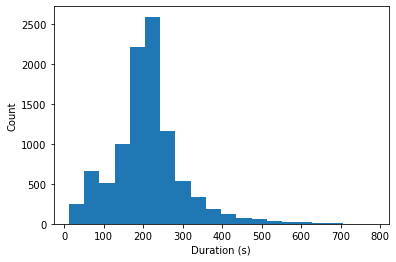

In [38]:
no_long_tracks = df[['duration_s', 'popularity_class']][df.duration_s < 800]
plt.hist(no_long_tracks.duration_s, bins=20)
plt.xlabel('Duration (s)')
plt.ylabel('Count')
plt.show()

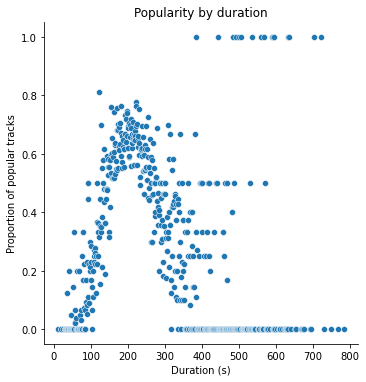

In [39]:
data = no_long_tracks.sort_values('duration_s').groupby(by='duration_s').mean()
_ = sns.relplot(x=data.index, y='popularity_class', data=data, kind='scatter')
_.set(title='Popularity by duration', xlabel=('Duration (s)'), ylabel='Proportion of popular tracks')
plt.show()

Another quadratic-like relationship. Popularity seems to peak for tracks around 200 seconds long. We can't make much of a judgment about tracks more than, say, 350 seconds long, due to the small number of such tracks in the sample. Still, there's enough order here to warrant inclusion in the model.

### ix. Tempo

Tempo is a song's speed, measured in beats per minute. How is `tempo` distributed?

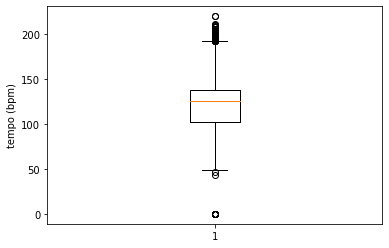

In [40]:
plt.boxplot(df.tempo)
plt.ylabel('tempo (bpm)')
plt.show()

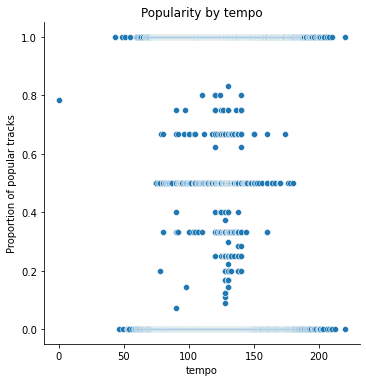

In [41]:
pop_prop_scatter('tempo')

Lots of noise. It doesn't appear to be useful to consider `tempo` as a predictor of popularity.

### x. Time signature and key

The `time_signature` and `key` columns are both categorical, corresponding to musical theory concepts elaborated upon in the previous notebook.

To visualize the relationship between these categories and their respective proportions of popular tracks, I will define a new plotting function that differs slightly from the scatterplot function I've been relying on.

In [42]:
def pop_prop_bar(x):
    """Create bar plot of the proportion of popular tracks over a given categorical feature"""
    pop_prop_by_x = df[[x, 'popularity_class']].sort_values(x).groupby(by=x).mean()
    _ = sns.catplot(x=pop_prop_by_x.index, y='popularity_class', data=pop_prop_by_x, kind='bar')
    _.set(title='Popularity by {}'.format(x), xlabel=x, ylabel='Proportion of popular tracks')
    plt.show()

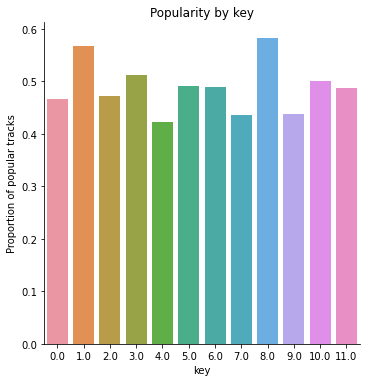

In [43]:
pop_prop_bar('key')

No obvious connection between `key` and popularity.

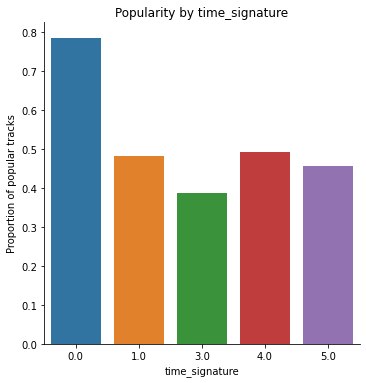

In [44]:
pop_prop_bar('time_signature')

This is a rather confusing result. Why would there be any tracks with a `time_signature` of zero? What's more, why would nearly 80% of those tracks be popular?

In [45]:
df.time_signature.value_counts()

4.0    9061
3.0     601
5.0     118
1.0      58
0.0      14
Name: time_signature, dtype: int64

Ah. There are only 14 such tracks. Presumably, Spotify uses zero to signify "other," for unusual time signatures. Or maybe they're spoken-word or other non-musical tracks. Apparently, most of them have above-50 popularity scores. Good for them.

What else can we make of the bar chart above? Not much, except that `time_signature` = 3 has a somewhat lesser proportion of popular tracks. The proportions are just disparate enough that I will tentatively include this feature, though I suspect it will be one of the first to be eliminated in the more thorough process of feature selection.

## xi. Available markets

Previously, I constructed a column to list the number of markets (i.e., countries) where the track is available. My guess is that tracks with wider availability will be more popular.

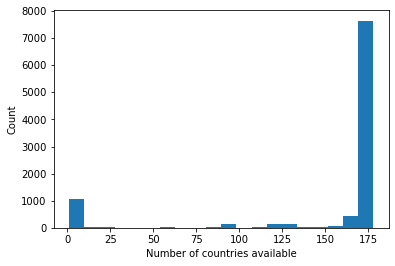

In [46]:
plt.hist(df.available_markets_total, bins=20)
plt.xlabel('Number of countries available')
plt.ylabel('Count')
plt.show()

About 1,000 tracks are available in very few markets, and nearly all of the rest are available in what appears to be the maximum number of countries. Given this distribution, it probably does not make sense to try to use this feature in my model. If there is any takeaway here, it's that artists should try to ensure they are part of the majority whose music is made available everywhere.

### xii. Loudness

Finally, we come to `loudness`, which contains mostly negative values, context for which can be found in the previous notebook. Let's take a look at the distribution.

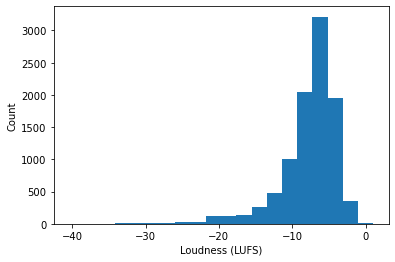

In [47]:
plt.hist(df.loudness, bins=20)
plt.xlabel('Loudness (LUFS)')
plt.ylabel('Count')
plt.show()

These values are distributed unimodally, skewed left (quiet). How does loudness relate to popularity?

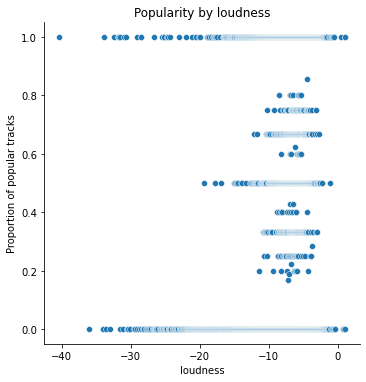

In [48]:
pop_prop_scatter('loudness')

In [49]:
len(df.loudness.unique())

6310

It's difficult to interpret this visualization as is, but one thing I notice is that popularity proportions of both 0 and 1.0 are common across the entire range of `loudness`. Seeing that there are over 6,000 unique `loudness` values, it seems likely that many of the individual values correspond to just one or two tracks, which would explain the sharp segmentation of popularity proportions (and the fact that most of the proportions are zero or one).

It may be more illustrative to plot `loudness` against the original `popularity_int`.

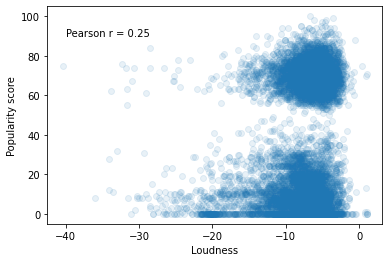

In [50]:
plt.scatter(x='loudness', y='popularity_int', data=df, alpha=0.1)
plt.xlabel('Loudness')
plt.ylabel('Popularity score')
plt.annotate('Pearson r = {}'.format(round(df[['loudness', 'popularity_int']].corr().iloc[0,1], 2)), (-40, 90))
plt.show()

As shown by both the plot and the correlation coefficient, there is a neglibile association. I can discount `loudness` in my model. 

## 3. Correlational matrix and heatmap

As we have seen, several of the relationships between individual features and popularity are not linear. So, we should not use Pearson correlation coefficients as the go-to indicator of importance. But we can use a correlational matrix and heatmap to get a broad sense of relationships. This should not be used for any further elimination of features, but may reinforce previous decisions to include certain features. If nothing else, may be interesting.

I will isolate only those quantitative values for which it would be mathematically viable to calculate Pearson's r, including my original `popularity_int` column as a basis for comparison.

In [51]:
df.columns

Index(['track_id', 'name', 'artist', 'album', 'year', 'popularity_int',
       'duration_ms', 'explicit', 'track_number', 'disc_number',
       'available_markets', 'album_type', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'mode', 'key',
       'available_markets_total', 'collab', 'popularity_class', 'single',
       'duration_s'],
      dtype='object')

In [52]:
df_corr = df[['popularity_int', 'duration_s', 'track_number', 'available_markets_total', 'danceability',\
    'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',\
    'valence', 'tempo', 'time_signature']]
df_corr.corr()

,popularity_int,duration_s,track_number,available_markets_total,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
popularity_int,1.000000,-0.058465,-0.337423,0.119345,0.277747,-0.117036,0.246256,0.081185,0.010677,-0.452996,-0.203937,0.055464,-0.042525,0.020981
duration_s,-0.058465,1.000000,-0.121837,0.098251,-0.071020,-0.020881,-0.030184,-0.022846,0.000506,0.016166,-0.000594,-0.127036,0.021269,0.016109
track_number,-0.337423,-0.121837,1.000000,-0.155112,-0.204532,0.303653,0.024978,-0.018794,-0.185648,0.312962,0.179389,-0.049943,0.100123,0.010894
available_markets_total,0.119345,0.098251,-0.155112,1.000000,0.103247,-0.194362,-0.115977,0.060176,0.149244,-0.075115,-0.092396,-0.035482,-0.030636,-0.039986
danceability,0.277747,-0.071020,-0.204532,0.103247,1.000000,-0.026121,0.200759,0.213082,-0.100342,-0.206614,-0.220846,0.317343,-0.064914,0.169398
energy,-0.117036,-0.020881,0.303653,-0.194362,-0.026121,1.000000,0.696170,-0.036492,-0.709143,0.024892,0.198373,0.305765,0.241780,0.203394
loudness,0.246256,-0.030184,0.024978,-0.115977,0.200759,0.696170,1.000000,-0.045841,-0.553011,-0.353707,-0.000083,0.283275,0.171920,0.201215
speechiness,0.081185,-0.022846,-0.018794,0.060176,0.213082,-0.036492,-0.045841,1.000000,0.050153,-0.125265,0.104558,0.015938,0.048379,0.020091
acousticness,0.010677,0.000506,-0.185648,0.149244,-0.100342,-0.709143,-0.553011,0.050153,1.000000,0.029258,-0.068564,-0.183882,-0.204274,-0.176229
instrumentalness,-0.452996,0.016166,0.312962,-0.075115,-0.206614,0.024892,-0.353707,-0.125265,0.029258,1.000000,0.065422,-0.185613,0.014171,-0.053061


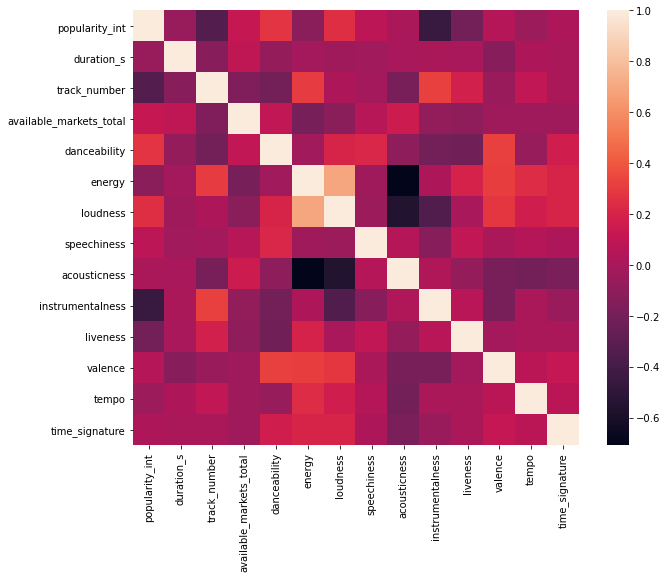

In [53]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(df_corr.corr())

This is more or less in line with the univariate and bivariate analyses conducted throughout the notebook.

## 4. Conclusion and next steps



Upon examining the individual features of my dataset, and how they relate to `popularity_class`, the early candidates for features to include in the model are:

* `track_number`
* `single`
* `danceability`
* `energy`
* `instrumentalness`
* `explicit`
* `collab`
* `duration_s`
* `time_signature`

Features that would seem safe to exclude are:
* `disc_number`
* `mode`
* `acousticness`
* `liveness`
* `tempo`
* `key`
* `available_markets_total`
* `available_markets`
* `duration_ms` (redundant)
* `loudness`

I will adjust the columns accordingly and export to .csv in preparation for the upcoming notebooks.

In [54]:
df = df[[
    'track_id',
    'popularity_class',
    'single',
    'danceability',
    'energy',
    'instrumentalness',
    'explicit',
    'collab',
    'duration_s',
    'time_signature'
]]

df.to_csv('../data/post_EDA.csv')